This part aims to predict the next coordinate by bayesian optimisation.

Use the package provided by: https://github.com/bayesian-optimization/BayesianOptimization

This package allows multi-dimensional data to be optimised. 

In [18]:
import pandas as pd
import numpy as np

In [4]:
#data prep
data_file = "bo_test_pca_df_mono_24.csv"
origin_data = pd.read_csv(data_file, index_col = None)
origin_data.head()


,Unnamed: 0,PC1,PC2,standardised_yield,yield
0,0,2.993404,1.292484,1.498429,0.82
1,1,-0.088412,-1.644992,1.081716,0.72
2,2,7.073370,1.667592,0.998374,0.70
3,3,4.542111,2.017177,0.665004,0.62
4,4,3.072163,-1.591613,0.248291,0.52


In [9]:
#PC1 PC2 are params, std_yield is target
#goal to maximise
data_for_bo_df = pd.DataFrame()
data_for_bo_df[['PC1', 'PC2', 'y']] = origin_data[['PC1', 'PC2', 'standardised_yield']]

In [10]:
data_for_bo_df.head()

,PC1,PC2,y
0,2.993404,1.292484,1.498429
1,-0.088412,-1.644992,1.081716
2,7.073370,1.667592,0.998374
3,4.542111,2.017177,0.665004
4,3.072163,-1.591613,0.248291


In [90]:
PC1 = data_for_bo_df['PC1'].values.tolist()
PC2 = data_for_bo_df['PC2'].values.tolist()
Y = (data_for_bo_df['y']).values.tolist()

The step above claimed the X series: PC1, PC2, and the observable: Y

We then need to specify a bound of each X component to make sure the predicition is made in a meaningful region.

In this example we use the min and max of each data series. 

In [41]:
#confirm pbounds
min_PC1= np.min(PC1)
max_PC1= np.max(PC1)
min_PC2= np.min(PC2)
max_PC2= np.max(PC2)



In [42]:
data_for_bo_df.describe()

,PC1,PC2,y
count,2.400000e+01,2.400000e+01,2.400000e+01
mean,-1.480297e-16,-1.480297e-16,-1.850372e-16
std,2.968293e+00,2.586961e+00,1.021508e+00
min,-3.931283e+00,-4.209722e+00,-1.876943e+00
25%,-2.393069e+00,-2.025052e+00,-8.768326e-01
50%,-7.950421e-01,-7.013078e-01,2.691268e-01
75%,2.706268e+00,1.754988e+00,7.170928e-01
max,7.073370e+00,6.346179e+00,1.498429e+00


In [91]:
PC1_pbound = tuple(data_for_bo_df['PC1'].describe()[['min', 'max']])
PC2_pbound = tuple(data_for_bo_df['PC2'].describe()[['min', 'max']])

In [92]:
PC1_pbound

(-3.931282944395187, 7.073369997919037)

In [93]:
print(PC1_low_bound)

-3.931282944395187


In [94]:
from bayes_opt import BayesianOptimization

Please refer to the link at the beginning of the document for detailed documentation of BayesianOptimization.

Important parameters: 

f - the imaginary function to generate data, which we don't need it because we are dealing with real-life experimental data, and we don't know the blackbox function underneath.

pbounds - the boundary we specified before, input as a dictionary with keys equal to the independent variable names, and values are tuples of min, max value.

verbose - how much metadata/information to print. verbose equals 2 will print all processing data, 1 will only print the final result, 0 will not give anything.

random_state - related to random process and ensure reproducibility in a certain level; doesn't matter too much and normally don't need to modify. 


In set_gp_params: a few hyperparameters of Gaussian process can be modified, such as alpha, kernel, etc. 

This document explained a few more details of gaussian process and terminologies there: https://github.com/xueannafang/learn_opt/blob/main/Bayesian_opt.ipynb
(More can be found on sklearn documentation page for gaussian process. 

As noticed in previous experience of dealing with real-life experimental data (https://github.com/xueannafang/learn_opt/blob/main/real_life_test_multi_dim_PCA_GP_UCB.ipynb), the noise level and kernel is very important for Gaussian process to give a reasonable outcome. 

By default, the BayesianOptimization package uses Matern, which works well for the example data used in this file. (Matern can modify the order of differential level of the interpolating curve and looks better than RBF as attempted before.)

The alpha value is related to the expected noise level of the data. In this example, because the data is collected by human in a benchtop reactor, with a few steps may affecting the yield (for example, sample stuck on the surface of container), we give it a relatively high noise level: 0.5. 

Again, in the last link we have visualise the GP results that those parameters are reasonable (i.e., the confidence interval is slightly less than the noise level). 

Users may need to play a little bit with hyperparameters if data coming from a different source/with a different level of noise or distribution. 

In [96]:
optimizer = BayesianOptimization(
    f=None,
    pbounds={'PC1': PC1_pbound, 'PC2': PC2_pbound},
    verbose=2,
    random_state=1,
)
optimizer.set_gp_params(alpha=0.5)

To use BayesianOptimization, we need to register our data point one by one, and here we put it in a loop:

In [97]:
#register our data
for pc1, pc2, y in zip(PC1, PC2, Y):
    params = {"PC1" : pc1, "PC2": pc2}
    optimizer.register(params=params, target=y)

The next step we will do the predicition for the next point. 

The BayesianOptimization package call the acqusition function as utility function. 
The difference and defintion of available functions are also touched on our step-to-step guide: 
https://github.com/xueannafang/learn_opt/blob/main/Bayesian_opt.ipynb 

Basically, we need to specify which type of utility func we want to use in the ```kind``` argument, and here is "ucb", same as our previous attempt.

Hyperparameters of ucb include the potential confidence interval related parameter, ```kappa```. 
The smaller ```kappa``` is, the more it's loyal to the original data (smaller confidence interval expected). 
(In our previous working example, when we directly used sklearn, this kappa is named as beta and we set it as 1.96 to represent 95% CI. Here we try to set it as 0, which also works.)

```xi``` is not relevant to ucb, it's used in "ei" or "poi" utility function as an indicator of exploration/exploitation tradeoff. 
(More are introduced in the original package: https://github.com/bayesian-optimization/BayesianOptimization/blob/master/bayes_opt/util.py)

In [129]:
#in this package, utility means aq func

from bayes_opt import UtilityFunction

utility = UtilityFunction(kind="ucb", kappa=0, xi=0.0)
# utility = UtilityFunction(kind="poi", kappa=0.1, xi=1e-5)

In the next step, we test the stability of prediction by making the predicition 20 times.

If the predicition is unstable, we expect to see lots of stars distributing everywhere on the canvas, that means we need to modify hyperparameters or kernels.

In this case it's good - we see the star centered at a small region, meaning the predicition is stable. 


- Why we have this step?

The BayesianOptimization package we directly imported ignored warning message if we check the source code. 
In our attempts we have noticed the warning message for gaussian process can however be useful, and we recommend still to manually check if the guanssian process gives the reasonable outcome.

(-4.209721501192254, 6.346178730753496)

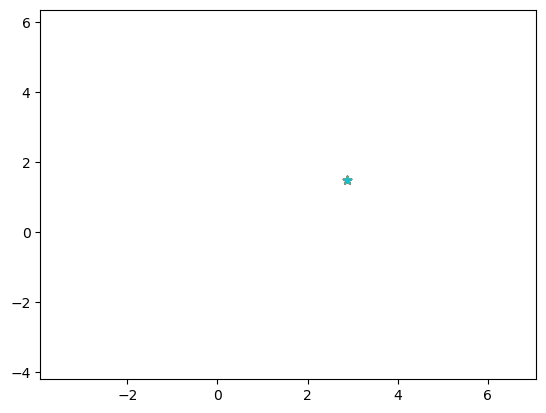

In [130]:
for i in range(20):
    this_res = optimizer.suggest(utility)
    plt.scatter(this_res["PC1"], this_res["PC2"], marker = "*")

plt.xlim(*PC1_pbound)
plt.ylim(*PC2_pbound)
    

And we can check the next PC to go:

In [131]:
res = optimizer.suggest(utility)

res

{'PC1': 2.868637338606409, 'PC2': 1.4695996421191246}

as well as the full calculation log

In [132]:
optimizer.res

[{'target': 1.4984287460757888,
  'params': {'PC1': 2.993403898202905, 'PC2': 1.2924838270266477}},
 {'target': 1.0817162326827536,
  'params': {'PC1': -0.0884123779106262, 'PC2': -1.6449915802570474}},
 {'target': 0.9983737300041464,
  'params': {'PC1': 7.073369997919037, 'PC2': 1.6675921172555643}},
 {'target': 0.6650037192897185,
  'params': {'PC1': 4.542111348031182, 'PC2': 2.0171772084671407}},
 {'target': 0.2482912058966834,
  'params': {'PC1': 3.072162802064814, 'PC2': -1.591613406713638}},
 {'target': -0.8351613289252081,
  'params': {'PC1': -2.3759722756622392, 'PC2': 6.346178730753496}},
 {'target': -1.3352163449968504,
  'params': {'PC1': -3.931282944395187, 'PC2': 3.913299487382204}},
 {'target': -1.876942612407796,
  'params': {'PC1': -2.444358776979994, 'PC2': -2.499060120004575}},
 {'target': -0.4601200668714765,
  'params': {'PC1': -0.5547383215387679, 'PC2': -1.8129500654901105}},
 {'target': 0.5399899652718079,
  'params': {'PC1': -1.0238577826136397, 'PC2': -1.984646

Visualise it together with our input data, note that the star is the predicited next point that likely would give a good target value. 

(Note that if the utility function is specified as other, for example the best position of improve the prediction, it would go for the region with highest uncertainty (because that region doesn't have sufficient data yet). 

In [133]:
import matplotlib.pyplot as plt

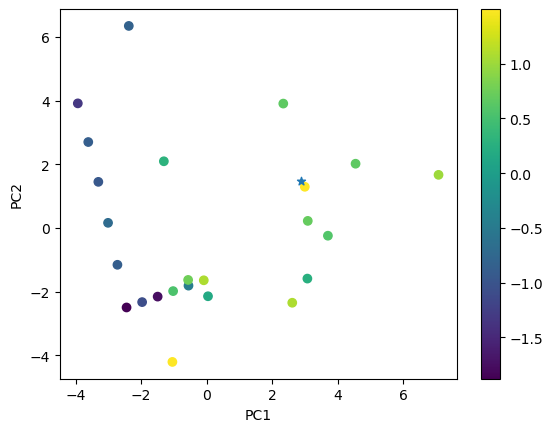

In [134]:
plt.scatter(PC1, PC2, c = Y)
plt.colorbar()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.scatter(res["PC1"], res["PC2"], marker = "*")

We can check the kernel detail and other information depends on our interests.. the main workflow has been completed. 

In [127]:
optimizer._gp

GaussianProcessRegressor(alpha=0.5, kernel=Matern(length_scale=1, nu=2.5),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=RandomState(MT19937) at 0x2BCE3A5A740)

In [128]:
data_for_bo_df.corr()

,PC1,PC2,y
PC1,1.000000e+00,-3.520252e-16,0.698695
PC2,-3.520252e-16,1.000000e+00,-0.116100
y,6.986947e-01,-1.160997e-01,1.000000
